In [3]:
from skimage import io,filters, morphology, measure, draw,exposure
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import trackpy as tp
import pandas as pd
from scipy.stats import median_abs_deviation
from scipy.optimize import curve_fit
from sklearn.neighbors import KernelDensity
from skimage.filters import threshold_otsu, threshold_multiotsu
import seaborn as sns

In [4]:
PATH = "<PATH/TO/DIR/>WAVE/Fig5E_S3I_PRD_truncation/Abi2_lamellipodia/"

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
def f_linear(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

In [7]:
def seg_cells(image, threshold, sigma,min_size, max_size, plot = True):
    """
    Segment out regions with a given fluorescence threshold in a cell
 
    Parameters
    ----------
    image : 2D array
        Raw tif image (single frame).
    threshold: float
        threshold used for segmentation
    sigma: float
        Standard deviation for Gaussian kernel.The larger the value, the smoothier the gaussian fitting.
    min_size: float
        minimum size of the segmented region
    max_size: float
        maximum size of the segmented region
    plot: bool
        whether or not plot the segmentation image
    
    Returns
    -------
    region_properties: list of RegionProperties
        Each item describes one labeled region with the corresponding attributes. 
    label_mask_clean:2D array 
        Segmentations based on fluorescent intensities of the image. 
        Each integer corresponds to a unique segmentation and 0 is the background.
        
    """
    smooth = filters.gaussian(image,sigma,preserve_range=True)
    cell_mask = smooth > threshold
    label_mask = measure.label(cell_mask)
    region_properties = measure.regionprops(label_mask)  
    label_mask_clean = label_mask.copy()
    for r in region_properties:
        if r.area <= min_size or r.area >= max_size:
            label_mask_clean[label_mask_clean == r.label] = 0
    if plot:
        plt.figure(figsize = (10,10))
        plt.imshow(image)
        plt.contour(label_mask_clean,colors = 'red',linewidths = 0.7)

    region_properties = measure.regionprops(label_mask_clean,intensity_image=image)
    return region_properties,label_mask_clean

# Quantification of lamellipodia

In [8]:
name = 'example_images/250318_eGFP-Abi2_fmlp_tirf_1-9_SIR.tif'
image = io.imread(PATH+name)

In [9]:
image.shape

(5, 1024, 1024)

In [10]:
# image = image.T

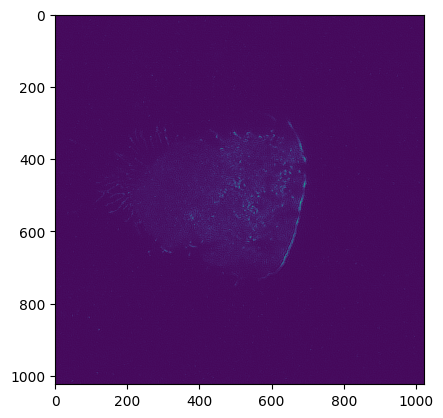

In [11]:
plt.imshow(image[0])

In [12]:
threshold_otsu(image)

64.91058

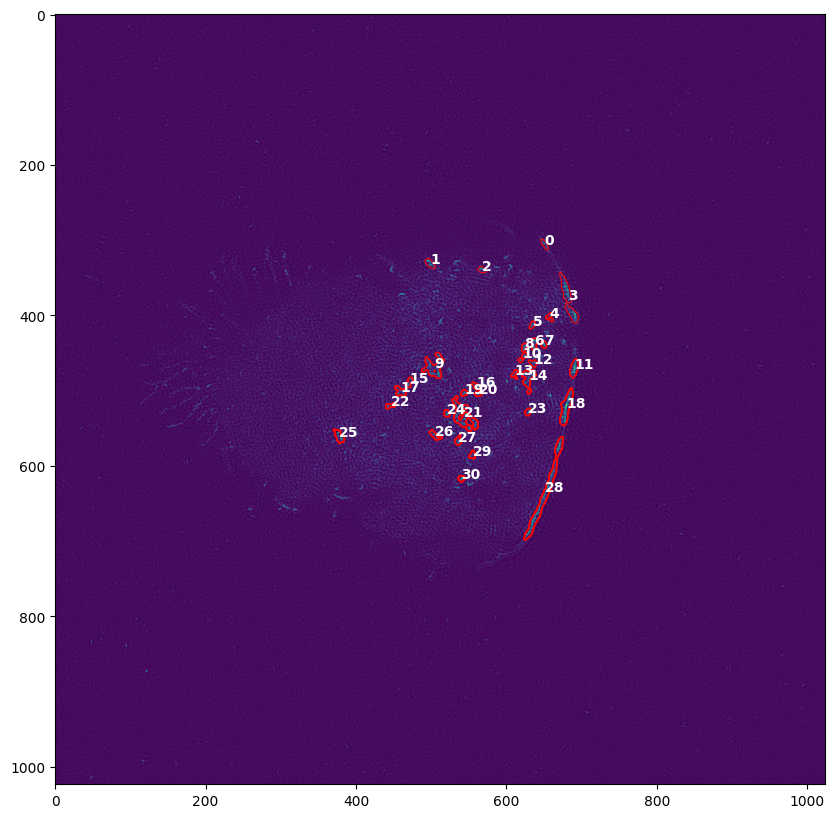

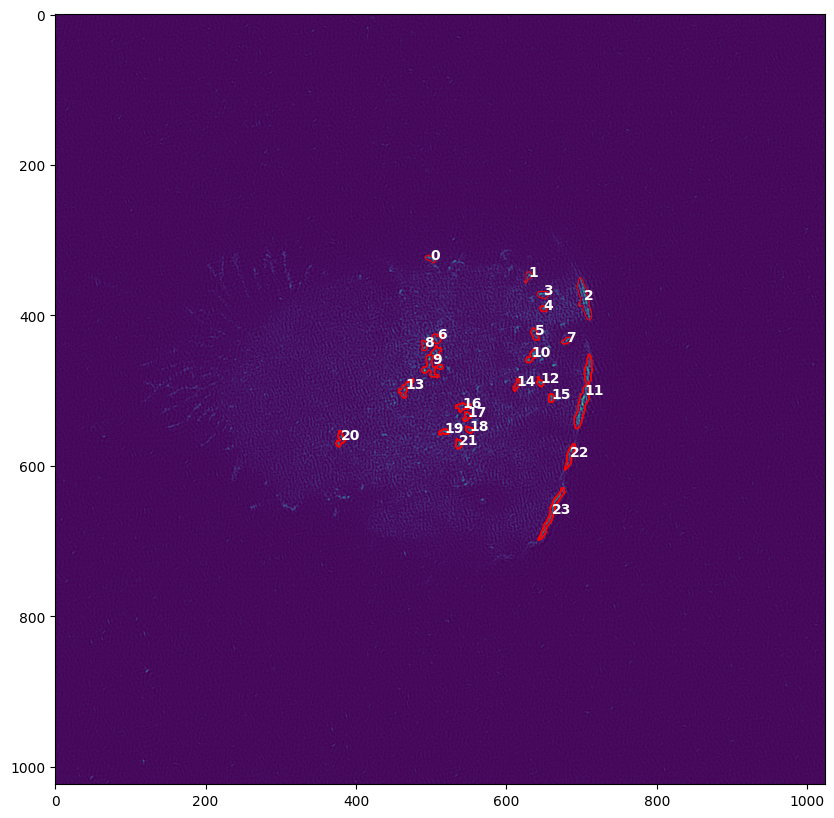

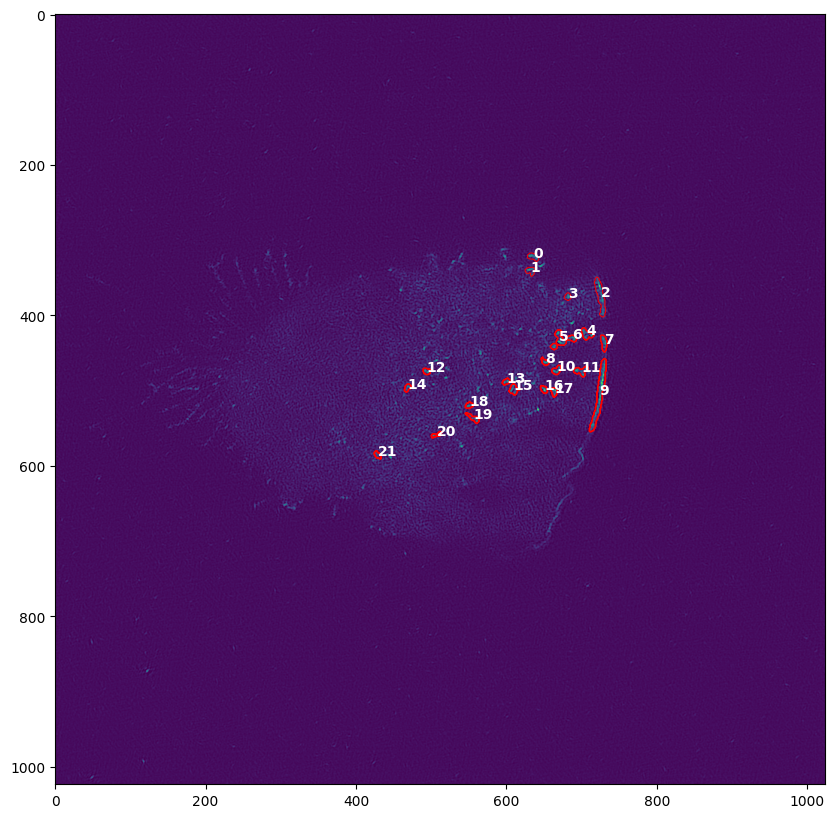

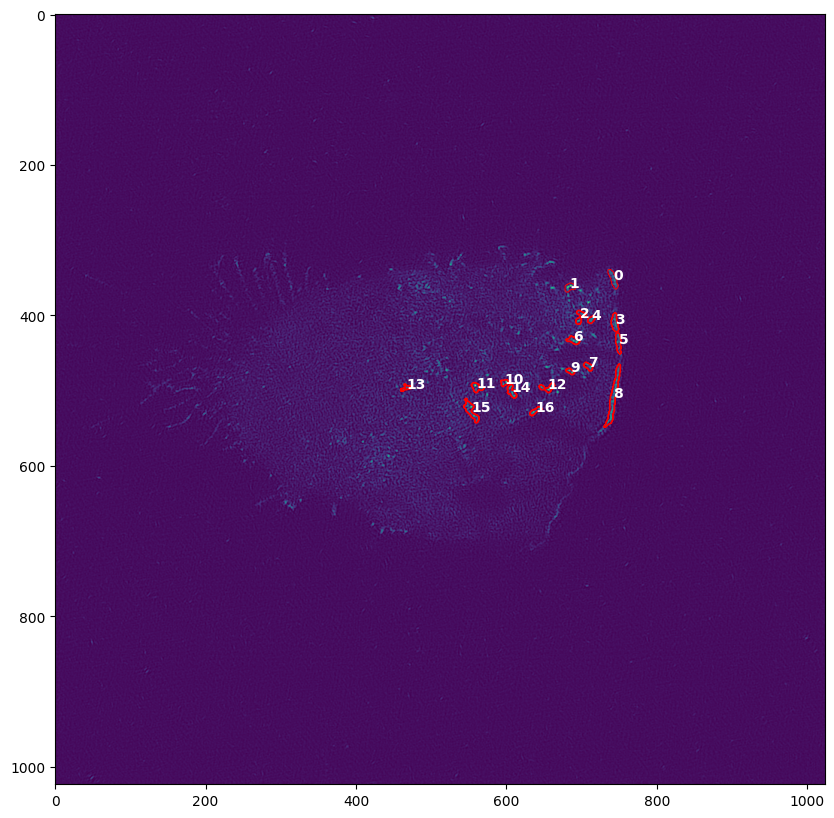

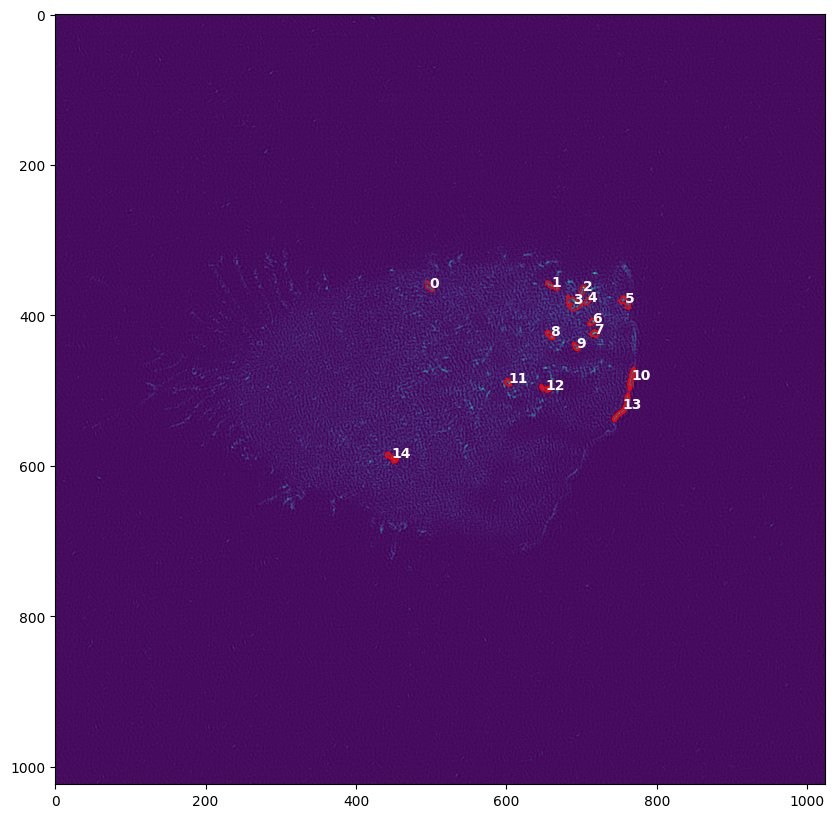

In [13]:
# Segmentation of lamellipodia for quantification
lamelli = pd.DataFrame()
p = 0
# threshold = threshold_otsu(image)
sigma = 2
# manually pick out the lammelipodia
num =[[0,3,11,18,28],[2,11,22,23],[2,7,9],[0,3,5,8],[5,10,13]]
for i in range(image.shape[0]):
    prop,label_mask_clean = seg_cells(image[i],115,sigma,50,10000000,True)
    for r in range(len(prop)): 
        y_center, x_center = prop[r].centroid # note that image coordinates are often given as (y, x) rather than (x, y)
        plt.text(x_center, y_center,r, fontweight = 'bold', color = 'white')

    for n in num[i]:
        lamelli.at[p,'intensity'] = prop[n].intensity_image.sum()
        lamelli.at[p,'area'] = prop[n].area
        lamelli.at[p,'perimeter'] = prop[n].perimeter_crofton
        lamelli.at[p,'unit_length_intensity'] = prop[n].intensity_image.sum()/prop[n].perimeter_crofton
        lamelli.at[p,'mean_intensity']= prop[n].intensity_mean
        lamelli.at[p,'label'] = n
        lamelli.at[p,'frame'] = i
        p += 1


In [14]:
lamelli

intensity   area   perimeter  unit_length_intensity  mean_intensity  \
0    11048.412109   62.0   35.835690             308.307507      178.200211   
1    91035.171875  461.0  157.956349             576.331199      197.473251   
2    44031.140625  188.0   59.049192             745.668810      234.208176   
3    93218.734375  424.0  111.949951             832.682222      219.855499   
4   183063.875000  934.0  304.171194             601.844878      195.999863   
5   100593.296875  468.0  127.348940             789.902896      214.942947   
6   168310.968750  789.0  211.603038             795.409036      213.321884   
7    35357.289062  194.0   78.470456             450.580902      182.254044   
8    67406.789062  380.0  161.097942             418.421169      177.386307   
9    63301.226562  334.0  112.830634             561.028721      189.524628   
10   26126.156250  129.0   51.004641             512.230964      202.528351   
11  139065.500000  665.0  203.423734             683.624753      209.121033   
12   27970.160156  147.0   59.834590             467.458040      190.273178   
13   31756.160156  163.0   58.263794             545.041065      194.823090   
14   26316.132812  141.0   61.270633             429.506460      186.639236   
15   92562.093750  475.0  178.774188             517.759832      194.867569   
16   19647.599609  114.0   50.123958             391.980212      172.347366   
17   24643.958984  134.0   65.848269             374.253708      183.910126   
18   32496.181641  173.0   90.211961             360.220323      187.839188   

    label  frame  
0     0.0    0.0  
1     3.0    0.0  
2    11.0    0.0  
3    18.0    0.0  
4    28.0    0.0  
5     2.0    1.0  
6    11.0    1.0  
7    22.0    1.0  
8    23.0    1.0  
9     2.0    2.0  
10    7.0    2.0  
11    9.0    2.0  
12    0.0    3.0  
13    3.0    3.0  
14    5.0    3.0  
15    8.0    3.0  
16    5.0    4.0  
17   10.0    4.0  
18   13.0    4.0

In [15]:
lamelli.mean_intensity.mean()


196.07978660181948

In [19]:
# result_lamelli = pd.DataFrame()

In [20]:
result_lamelli.at[len(result_lamelli),'unit_length_intensity'] = lamelli.unit_length_intensity.mean()
result_lamelli.at[len(result_lamelli)-1,'mean_intensity'] = lamelli.mean_intensity.mean()
result_lamelli.at[len(result_lamelli)-1,'cell'] = name

In [21]:
result_lamelli

unit_length_intensity  mean_intensity  \
0             545.381721      196.079787   

                                                cell  
0  example_images/250318_eGFP-Abi2_fmlp_tirf_1-9_...

## Quantification of cytosolic expression level

In [22]:
name = "example_images/250318_Abi2-eGFP_epi_1-9.tif"
image_epi = io.imread(PATH + name)

In [23]:
# image_epi = image_epi.T

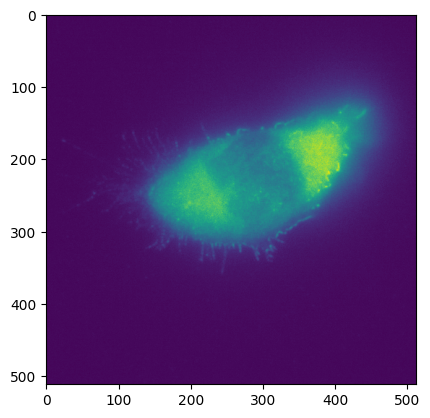

In [24]:
plt.imshow(image_epi[2])

In [25]:
thres = threshold_otsu(image_epi)
thres

851

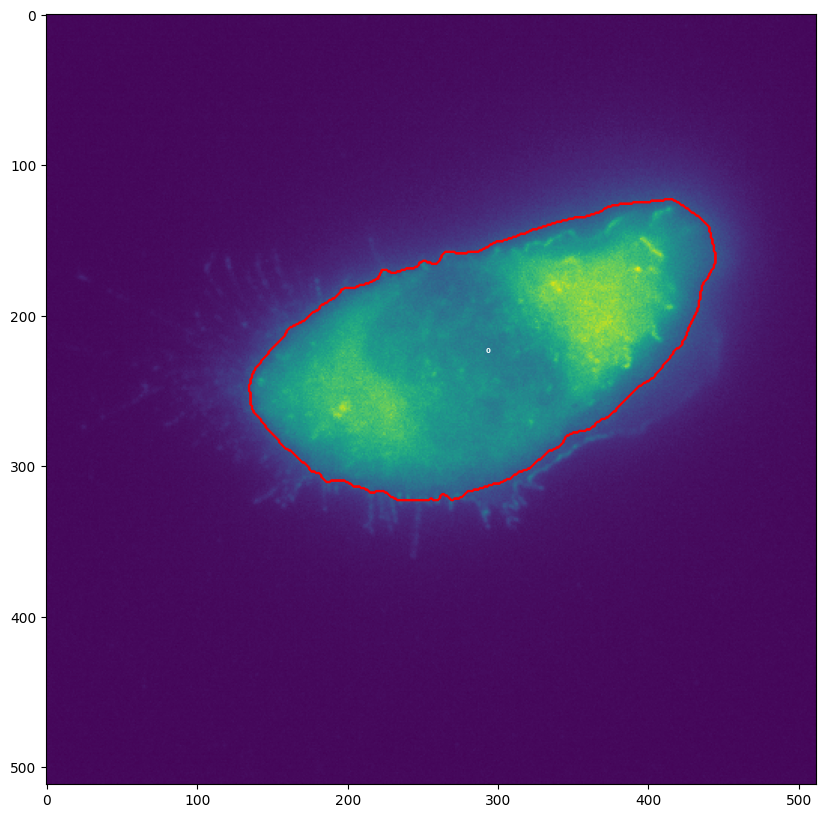

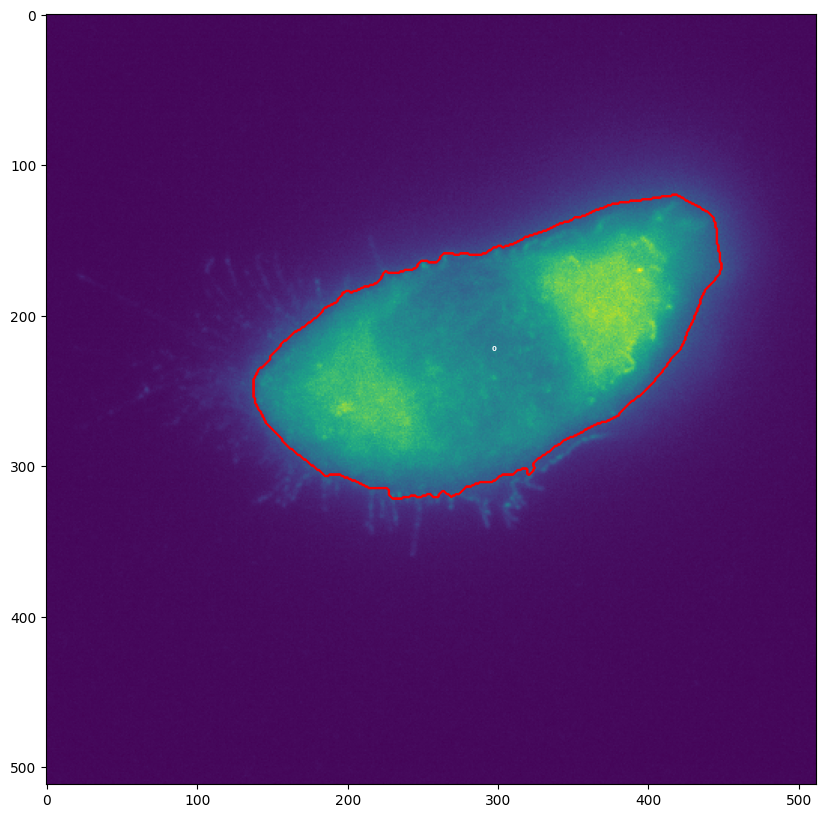

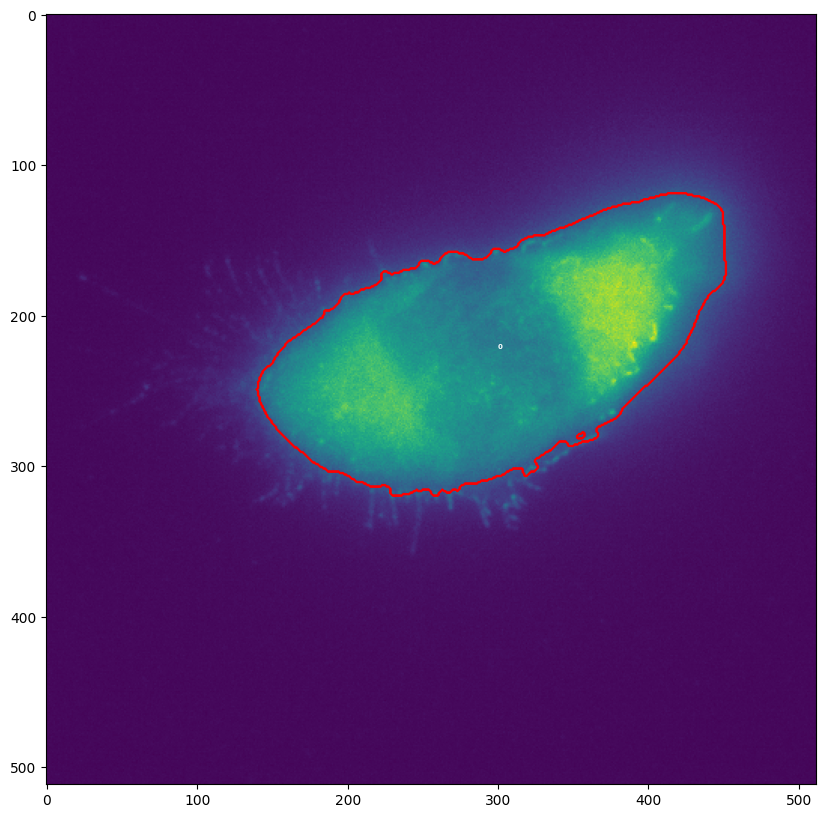

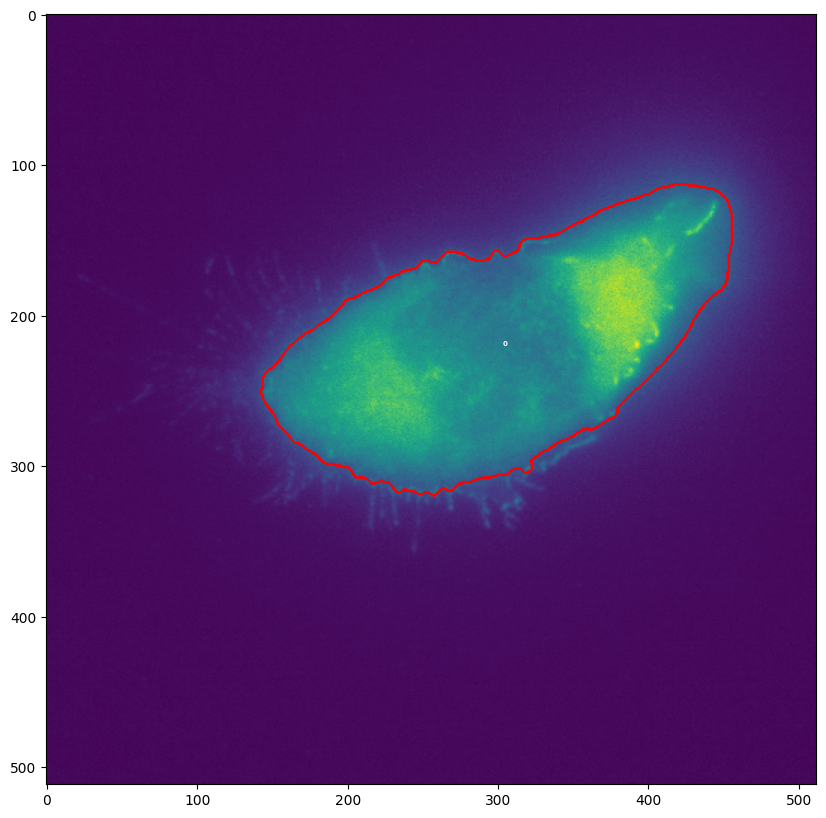

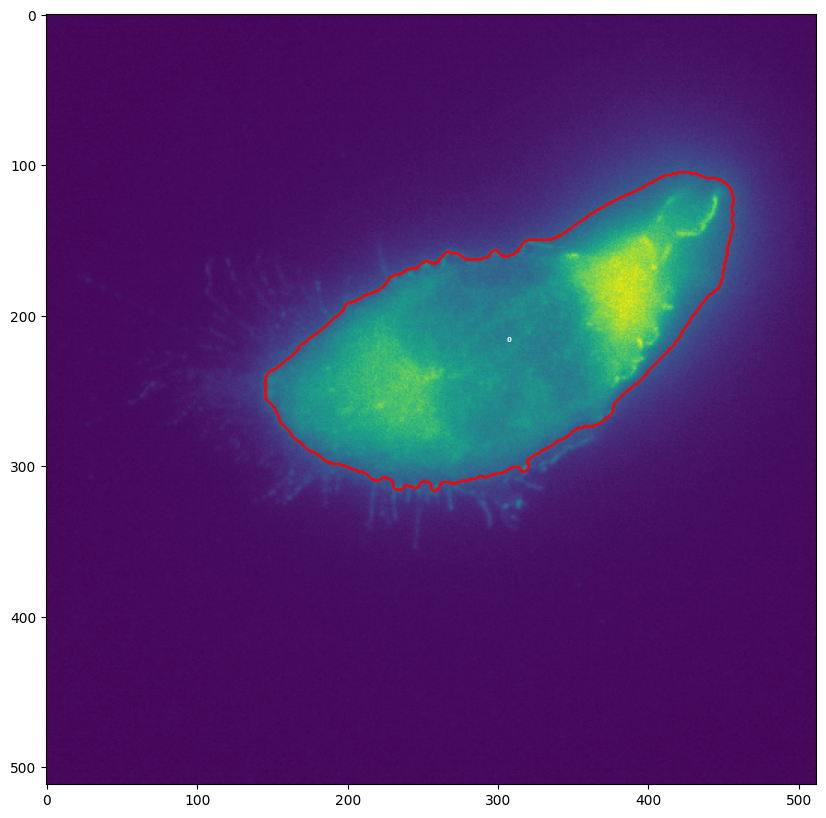

In [26]:
features = pd.DataFrame()
for i in range(len(image_epi)):
    prop,label_mask_clean = seg_cells(image_epi[i],thres,2,18000,1200000,True)
    
    for j in range(len(prop)): 
        y_center, x_center = prop[j].centroid # note that image coordinates are often given as (y, x) rather than (x, y)
        plt.text(x_center, y_center, str(j), fontweight = 'bold', color = 'white',size = 5)

        features = features.append([{'label':prop[j].label,'x': prop[j].centroid[0],
                                 'y': prop[j].centroid[1],'frame': i,
                                    'area':prop[j].area,'intensity':prop[j].intensity_mean}])
epi_intens = features.intensity.mean()

In [27]:
features

label           x           y  frame   area    intensity
0      1  224.348523  291.719198      0  38821  1518.425002
0      1  223.066073  295.907877      1  38427  1484.632342
0      1  222.001860  299.711710      2  38163  1462.715877
0      1  219.605732  303.373817      3  37406  1445.969818
0      1  217.070522  305.905743      4  36655  1431.627036

In [28]:
epi_intens

1468.6740147921432

In [44]:
# express_level_lamel = pd.DataFrame()

In [45]:
express_level_lamel.at[len(express_level_lamel),'express_level'] = epi_intens
express_level_lamel.at[len(express_level_lamel)-1,'cell'] = name

In [46]:
express_level_lamel

express_level                                         cell
0    1468.674015  example_images/250318_Abi2-eGFP_epi_1-9.tif

### 

# Generate plots

In [29]:
express_level_Abi2_FL = pd.read_csv(PATH + 'csv_files/Abi2-FL_expression_level.csv',index_col=0)
express_level_Abi2_dPRD = pd.read_csv(PATH + 'csv_files/Abi2-dPRD_expression_level.csv',index_col=0)

In [30]:
result_lamelli_Abi2_FL = pd.read_csv(PATH +'csv_files/Abi2-FL_unit_length_intensity.csv',index_col=0)
result_lamelli_Abi2_dPRD = pd.read_csv(PATH +'csv_files/Abi2-dPRD_unit_length_intensity.csv',index_col=0)

In [31]:
result_fmlp = pd.DataFrame()

In [32]:
result_fmlp['Abi2'] = result_lamelli_Abi2_FL['mean_intensity']/express_level_Abi2_FL['express_level']


In [33]:
result_fmlp['Abi2ΔPRD'] = result_lamelli_Abi2_dPRD['mean_intensity']/express_level_Abi2_dPRD['express_level']


In [34]:
result_fmlp

Abi2  Abi2ΔPRD
0   0.176224  0.059295
1   0.141319  0.152936
2   0.113203  0.139295
3   0.224004  0.096040
4   0.178731  0.062910
5   0.217303  0.080626
6   0.114750  0.085850
7   0.131339  0.058173
8   0.204590  0.082226
9   0.172093  0.083524
10  0.125313  0.069014
11  0.157934  0.065239
12  0.209796  0.059661
13  0.110091  0.076233
14  0.127615  0.111650
15  0.087196  0.036131
16  0.080537       NaN
17  0.074417       NaN

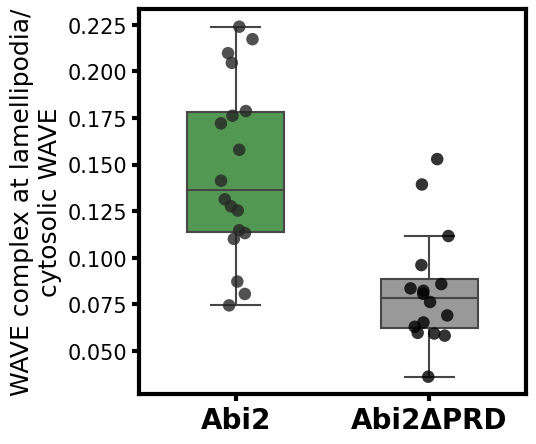

In [37]:
_,ax = plt.subplots(figsize = (5,5))
c = ['#48a446','#999999']
sns.boxplot(result_fmlp,width = 0.5,palette=c,showfliers= False)
sns.stripplot(result_fmlp,color = 'black',size = 9,alpha = 0.8,edgecolor = 'black')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

# increase tick width
ax.tick_params(width=3,size = 5)
plt.yticks(size = 15)
plt.xticks(size = 20,fontweight = 'bold')
plt.ylabel('WAVE complex at lamellipodia/\ncytosolic WAVE',size = 18)
plt.savefig(PATH +'FigureS3I_Abi2_lamellipodia.png',bbox_inches= 'tight',dpi = 300)